## Configuración de paquetes base

In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 318, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 127, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 3

In [ ]:
## General modules
import pandas as pd
import numpy as np
import time
import os
from scipy import stats as sp_stats
from sklearn.model_selection import train_test_split
import shutil
from google.colab import drive
import matplotlib.pyplot as plt
from random import shuffle, seed
from sklearn.model_selection import ParameterGrid

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Calibration modules
from sklearn import metrics
from sklearn import calibration

In [ ]:
## GoogleDrive Connection
drive.mount('/content/drive')

## Configuración de paquetes de Github

In [ ]:
## Instal QMC package
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/fagonzalezo/qmc.git
else:
    import sys
    sys.path.insert(0, "../")

In [ ]:
## Install calibration package
!pip install git+https://github.com/uu-sml/calibration.git

El paquete de _calibration_ tal cual como viene de github, no trae la carpeta de _utils_ donde están las distancias que se pueden utilizar. Adicionalmente, la inicialización del paquete no contiene nada, por lo cual se debe solucionar este problema con los siguientes.

In [ ]:
## Path in where files to fix clone of calibration module are
path_in = "/content/drive/MyDrive/Trabajo de Grado Maestría/Librería Calibration/"

## Path out where files to fix clone of calibration module have to be
path_out = "/usr/local/lib/python3.8/dist-packages/calibration/"

## Create folder 
if not os.path.isdir(path_out + "utils"):
  os.mkdir(path_out + "utils")

## Copy files
shutil.copyfile(path_in + "distances.py", path_out + "utils/distances.py")
shutil.copyfile(path_in + "__init__.py", path_out + "utils/__init__.py")

In [ ]:
## Calibration functions
import calibration.stats as cali_stats
import calibration.utils as cali_utils
import calibration.binning as cali_binning
import calibration.sample as cali_sample
import calibration.lenses as cali_lenses 

In [ ]:
## QMC libraries
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as modelsbb

from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import *

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import backend

## Calibration functions

In [ ]:
#===================================#
#     Class-wise ECE for tensors    #    
#===================================#
def cwECE_tf(y_true, y_pred):
  n_bins = 15
  
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = 0.0

  ## Calculate ECE for each class
  for k in range(y_pred.shape[1]):
    ## Store probs and observations
    confidences = y_pred[:,k]
    accuracies = y_pred[:,k] == 1

    ece = 0.0
    # ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
      prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

      if prop_in_bin > 0:
          accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
          avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
          ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    ## Store values 
    ece_list += ece

  ece_list = ece_list/y_pred.shape[1]

  return ece_list

#========================================#
#   Maximum confidence ECE for tensors   #
#========================================#
def maxECE_tf(y_true, y_pred):
  n_bins = 15

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = tf.math.reduce_max(y_pred, axis = 1)
  predictions = tf.math.argmax(y_pred, axis = 1)
  accuracies = predictions == tf.math.argmax(y_true, axis = 1)

  ## Confidence and predictions in each bin
  ece = 0.0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
    prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

    if prop_in_bin > 0:
        accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
        avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
        ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      
  return ece

#================================#
#          Class-wise ECE        #
#================================#
def cwECE(n_bins, probs, obs, metric):
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = []

  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Calculate ECE for each class
  for k in range(probs.shape[1]):
    
    ## Store probs and observations
    confidences = probs[:,k]
    accuracies = obs[:,k] == 1

    ## Lists to store values to plot the reliability diagram
    conf = []
    acc = []
    bin = []

    ece = 0
    ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):       
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower)*(confidences <= bin_upper)      
      prop_in_bin = np.mean(in_bin)
      if prop_in_bin > 0:
        accuracy_in_bin = np.mean(accuracies[in_bin])
        avg_confidence_in_bin = np.mean(confidences[in_bin])
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        conf += [avg_confidence_in_bin]
        acc += [accuracy_in_bin]
        bin += [(bin_lower + bin_upper)/2]        
        del in_bin, prop_in_bin, accuracy_in_bin, avg_confidence_in_bin
    ## Store values
    conf_list += [conf]
    acc_list += [acc]
    bin_list += [bin]    
    ece_list += [ece]
    del conf, acc, bin, ece
  
  if metric is True:
    return np.mean(ece_list)
  else:
    return ece_list, conf_list, acc_list, bin_list

#================================#
#    Maximum confidence ECE      #
#================================#
def maxECE(n_bins, probs, obs, metric):
  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = probs.max(axis = 1)
  predictions = probs.argmax(axis = 1)
  accuracies = probs.argmax(axis = 1) == obs.argmax(axis = 1)

  ## Confidence and predictions in each bin
  ece = 0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower)*(confidences <= bin_upper)
    prop_in_bin = np.mean(in_bin)  

    if prop_in_bin > 0:
      accuracy_in_bin = np.mean(accuracies[in_bin])
      avg_confidence_in_bin = np.mean(confidences[in_bin])
      ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      conf_list += [avg_confidence_in_bin]
      acc_list += [accuracy_in_bin]
      bin_list += [(bin_lower + bin_upper)/2]   

  if metric is True:
    return ece
  else: 
    return ece, conf_list, acc_list, bin_list

#========================#
#   Brier multiclass     #
#========================#
def brier_multi(targets, probs):
  """ 
  targets: Numpy array of one-hot encoding of observed labels with shape (n, classes)
  probs: Numpy array of probs for each class with shape (n, classes)
  """
  return np.mean(np.sum((probs - targets)**2, axis = 1))

#================================================#
#   Function to calculate calibration metrics    #
#================================================#
def resume_metrics(X_test, Y_test, T_test, model, nbins, p_value):
  """
  Arguments:
    X_test    : Covariates for testing (n,p)
    Y_test    : Target variable dimension for testing (n,)
    T_test    : One hot encoding of the target variable dimension for testing (n,c)
    p_value   : Whether it should be done the resampling to obtain the p-value of ece metrics

    model     : Model object that contains .predict function to obtain the probabilities for each class    
    nbins     : Number of equally sized bins created

  where: 
    c: Number of classes
    p: number of covariates
    n: Number of observations

  It returns a tuple with pandas data.frames with results of calibration metrics 
  """
  
  #==============================================#
  #                 Organize data                #
  #==============================================#
  ## Predictions on test
  pred_test = model.predict(X_test, verbose = 0)
  
  ## Most confident probability predictions (Maximum lenses)
  pred_test_max, T_test_max = cali_lenses.maximum_lens(probs = pred_test, y = T_test)

  #=============================================================================#
  #                  Expected Calibration Error                                 #
  #=============================================================================#
  ## Cambiar nombres
  ## ECE + dependent binning + tvdistance
  ece_max_uni = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean"))

  ## ECE + uniform binning + tvdistance
  ece_max_dep = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.UniformBinning(bins = nbins))

  ## cwECE + uniform binning
  ece_cw_uni = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = True)

  #======================================================#
  #       Samples under perfect calibration (ECE)        #
  #======================================================#

  if p_value:
    np.random.seed(6164)
    ## ECE + dependent binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance,
                                binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean")),
                                n = 1000)
    
    # Generate samples
    ece_max_dep_sample = resample(pred_test_max)
    del resample

    ## ECE + uniform binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance, 
                                binning = cali_binning.UniformBinning(bins = nbins)),
                                n = 1000)

    # Generate samples
    ece_max_uni_sample = resample(pred_test_max)
    del resample

    ## cw-ECE + uniform binning
    # Define Resampling
    resample = cali_sample.ResampleStats(lambda x: cwECE(n_bins = nbins, probs = x, obs = T_test, metric = True), n = 1000)

    # Generate samples
    ece_cw_uni_sample = resample(pred_test)

    #====================================================================#
    #    P-value of ECE under assumption of perfect calibration (ECE)    #
    #====================================================================#
    ## Data dependent binning + tv distance
    p_data_max = 1 - sp_stats.percentileofscore(ece_max_dep_sample, ece_max_dep)/100

    ## Uniform binning + tv distance
    p_uni_max = 1 - sp_stats.percentileofscore(ece_max_uni_sample, ece_max_uni)/100

    ## Uniform binning + tv distance
    p_uni_cw = 1 - sp_stats.percentileofscore(ece_cw_uni_sample, ece_cw_uni)/100
  
  #==================================#
  #          Brier score             #
  #==================================#  
  ## Brier for all classes
  bri_full = brier_multi(targets = T_test, probs = pred_test)

  ## Brier for most confidence class
  bri_max = brier_multi(targets = T_test_max, probs = pred_test_max)

  #===========================#
  #           Log Loss        #
  #===========================#
  loss_full = metrics.log_loss(y_true = T_test, y_pred = pred_test)
  loss_maxx = metrics.log_loss(y_true = T_test_max, y_pred = pred_test_max)

  #=================================================#
  #                 Reliability Diagram             #
  #=================================================#
  ## Class-wise reliability diagram and ECE individually
  cw_ece_list, cw_conf_list, cw_acc_list, cw_bin_list = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = False)

  ## Most confident prediction 
  max_ece, max_conf_list, max_acc_list, max_bin_list = maxECE(n_bins = nbins, probs = pred_test_max, obs = T_test_max, metric = False)

  ## Organize data
  diag_cw = pd.DataFrame({"ece" : cw_ece_list, "conf" : cw_conf_list, "acc" : cw_acc_list, "bin" : cw_bin_list})
  diag_max = pd.DataFrame({"ece" : max_ece, "conf" : max_conf_list, "acc" : max_acc_list, "bin" : max_bin_list})

  #=============================#
  #   Combine all the results   #
  #=============================#
  if p_value:
    ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.mean(ece_max_dep_sample), np.mean(ece_max_uni_sample), np.mean(ece_cw_uni_sample) ],
        "ECE perfcect std" : [np.std(ece_max_dep_sample), np.std(ece_max_uni_sample), np.std(ece_cw_uni_sample) ],
        "ECE p-value" : [p_data_max, p_uni_max, p_uni_cw] })
  else: 
        ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.nan, np.nan, np.nan ],
        "ECE perfcect std" : [np.nan, np.nan, np.nan ],
        "ECE p-value" : [np.nan, np.nan, np.nan ] })
  
  global_metrics = pd.DataFrame({
      "Brier_full" : [bri_full],
      "Brier_maximum" : [bri_max],
      "Log-loss_full" : [loss_full],
      "Log-loss_maximum" : [loss_maxx] })
  
  return global_metrics, global_metrics_ece, diag_max, diag_cw


#=====================================================================#
#           Function to plot the results of the optimization          #
#=====================================================================#
def GraphOptimizationMetrics(df_metrics, df_metrics_ece, par_row, par_col, name_par_row, name_par_col):
  """  
  This functions plot the results of global and calibration metrics output of resume_metrics.

  df_metrics: It is a pandas dataframe that corresponds to the "gm" object
  df_metrics_ece: It is a pandas dataframe that corresponds to the "gm_ece" object
  par_row: String of the name of the parameter in the tables to display in the row heatmap
  par_col: String of the name of the parameter in the tables to display in the columns heatmap
  name_par_row: String of the name of the parameter to display in the row heatmap
  name_par_col: String of the name of the parameter to display in the column heatmap

  Output a grid of plots with some of the results
  """
  ## Subset data
  ece_cw = df_metrics_ece.loc[df_metrics_ece["Approach"] == "CW",:]
  ece_max_u = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Uniform"),:]
  ece_max_d = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Data"),:]

  ## Format for ticks
  majorFormatter = FormatStrFormatter('%.2f')

  ## Color map for heatmaps
  color_map = "flare_r"#"Greys_r"#"flare_r"

  if df_metrics[par_col].unique().shape[0] != 1:
    fig, axis = plt.subplots(2, 4, figsize = (20,8))

    ##====== Log-loss    
    dd = df_metrics.pivot(par_row, par_col, "Log-loss_full")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                ax = axis[0,0],
                cmap = color_map,
                cbar_kws={'label': ''})

    axis[0,0].set_xlabel(name_par_col)
    axis[0,0].set_ylabel(name_par_row)
    axis[0,0].set_title("Log-loss (Validation)")
    # axis[0,0].xaxis.set_major_formatter(majorFormatter)
    axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy train
    dd = df_metrics.pivot(par_row, par_col, "acc_train")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map.replace("_r",""),
                ax = axis[0,1],
                cbar_kws={'label': ''})

    axis[0,1].set_xlabel(name_par_col)
    axis[0,1].set_ylabel(name_par_row)
    axis[0,1].set_title("Accuracy (Training)")
    #axis[0,1].xaxis.set_major_formatter(majorFormatter)
    axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy validation
    dd = df_metrics.pivot(par_row, par_col, "acc_val")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map.replace("_r",""),
                ax = axis[0,2],
                cbar_kws={'label': ''})

    axis[0,2].set_xlabel(name_par_col)
    axis[0,2].set_ylabel(name_par_row)
    axis[0,2].set_title("Accuracy (Validation)")
    #axis[0,2].xaxis.set_major_formatter(majorFormatter)
    axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Blank plot
    axis[0,3].set_visible(False)

    ##====== Brier
    dd = df_metrics.pivot(par_row, par_col, "Brier_full")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map,
                ax = axis[1,0],
                cbar_kws={'label': ''})

    axis[1,0].set_xlabel(name_par_col)
    axis[1,0].set_ylabel(name_par_row)
    axis[1,0].set_title("Brier Score (Validation)")
    #axis[1,0].xaxis.set_major_formatter(majorFormatter)
    axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE uniform
    dd = ece_max_u.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd, 
                cmap = color_map,
                ax = axis[1,1],
                cbar_kws={'label': ''})

    axis[1,1].set_xlabel(name_par_col)
    axis[1,1].set_ylabel(name_par_row)
    axis[1,1].set_title("ECE-uniform\n(Validation)")
    #axis[1,1].xaxis.set_major_formatter(majorFormatter)    
    axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE data
    dd = ece_max_d.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd, 
                cmap = color_map,
                ax = axis[1,2],
                cbar_kws={'label': ''})

    axis[1,2].set_xlabel(name_par_col)
    axis[1,2].set_ylabel(name_par_row)
    axis[1,2].set_title("ECE-data\n(Validation)")
    #axis[1,2].xaxis.set_major_formatter(majorFormatter)    
    axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== CW-ECE
    dd = ece_cw.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd, 
                cmap = color_map,
                ax = axis[1,3],
                cbar_kws={'label': ''})

    axis[1,3].set_xlabel(name_par_col)
    axis[1,3].set_ylabel(name_par_row)
    axis[1,3].set_title("classwise-ECE\n(Validation)")
    #axis[1,3].xaxis.set_major_formatter(majorFormatter)    
    axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

    ## Adjust space between plots
    fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
    #plt.show()
  else:
    fig, axis = plt.subplots(2, 4, figsize = (20,8))

    ##====== Log-loss
    axis[0,0].plot(df_metrics[par_row], df_metrics["Log-loss_full"], ".-", color = "#6F6F6F")
    axis[0,0].set_xlabel(name_par_row)
    axis[0,0].set_ylabel("Log-loss")
    axis[0,0].set_title("Log-loss (Validation)")    
    axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy train
    axis[0,1].plot(df_metrics[par_row], df_metrics["acc_train"], ".-", color = "#6F6F6F")
    axis[0,1].set_xlabel(name_par_row)
    axis[0,1].set_ylabel("Accuracy")
    axis[0,1].set_title("Accuracy (Training)")    
    axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy validation
    axis[0,2].plot(df_metrics[par_row], df_metrics["acc_val"], ".-", color = "#6F6F6F")
    axis[0,2].set_xlabel(name_par_row)
    axis[0,2].set_ylabel("Accuracy")
    axis[0,2].set_title("Accuracy (Validation)")    
    axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Blank plot
    axis[0,3].set_visible(False)

    ##====== Brier
    axis[1,0].plot(df_metrics[par_row], df_metrics["Brier_full"], ".-", color = "#6F6F6F")
    axis[1,0].set_xlabel(name_par_row)
    axis[1,0].set_ylabel("Brier Score")
    axis[1,0].set_title("Brier Score (Validation)")    
    axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE uniform
    axis[1,1].plot(ece_max_u[par_row], ece_max_u["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,1].set_xlabel(name_par_row)
    axis[1,1].set_ylabel("ECE-uniform")
    axis[1,1].set_title("ECE-uniform\n(Validation)")    
    axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE data
    axis[1,2].plot(ece_max_d[par_row], ece_max_d["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,2].set_xlabel(name_par_row)
    axis[1,2].set_ylabel("ECE-data dependent")
    axis[1,2].set_title("ECE-data\n(Validation)")    
    axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== CW-ECE
    axis[1,3].plot(ece_cw[par_row], ece_cw["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,3].set_xlabel(name_par_row)
    axis[1,3].set_ylabel("cwECE")
    axis[1,3].set_title("classwise-ECE\n(Validation)")    
    axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

    ## Adjust space between plots
    fig.subplots_adjust(hspace = 0.5, wspace = 0.25)
    #plt.show()
  return None

#=======================#
#   Reliability Plot    #
#=======================#
plt.style.use('seaborn-darkgrid')

def ReliabilityDiagram(df_gram, diagram, nr_plt, nc_plt, w_plt, h_plt):
  """ 
  Function to plot the reliability diagram for the most confident prediction or
  for the class-wise results.

  df_gram: Pandas dataframe with the data to plot
  diagram: Whether "max" or "cw" reliability diagram
  nr_plt: Number of row plots for the classwise option
  nc_plt: Number of column plots for the classwise option
  w_plt: Size of the width of the figure
  h_plt: Size of the height of the figure
  """

  ##=========== Reliability diagram (most confident prediction)
  if diagram == "max":
    dd = df_gram
    ece = np.round(df_gram.loc[:,"ece"].tolist()[0],4)
    n_bins = 15

    plt.figure(figsize = (w_plt, h_plt))

    plt.plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
    plt.bar(dd["bin"], dd["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
    plt.text(0.05, 0.9, f"ECE-uniform: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
    plt.ylabel("Average Accuracy")
    plt.xlabel("Average Confidence")
    plt.title("ECE-uniform", fontsize = 18)

    # plt.show()

  ##=========== Reliability diagram (classwise)
  if diagram == "cw":
    dd = df_gram
    n_bins = 15

    fig, ax = plt.subplots(nr_plt, nc_plt, sharey = True, sharex = True, figsize = (w_plt, h_plt))

    if nr_plt == 1:
      for i in range(nc_plt):
        ece = np.round(df_gram.iloc[i,:]["ece"],4)

        ax[i].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
        ax[i].bar(dd.iloc[i,:]["bin"], dd.iloc[i,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
        ax[i].set_title(f"Class {str(i)}")
        ax[i].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
        ax[i].set_ylabel("Average Accuracy")
        ax[i].set_xlabel("Average Confidence")
    else:
      c = 0
      for i in range(nr_plt):
        for j in range(nc_plt):
          if c < dd.shape[0]:
            ece = np.round(df_gram.iloc[c,:]["ece"],4)

            ax[i,j].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
            ax[i,j].bar(dd.iloc[c,:]["bin"], dd.iloc[c,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
            ax[i,j].set_title(f"Class {str(c)}")
            ax[i,j].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white",'alpha': 1, 'pad': 10})
            ax[i,j].set_ylabel("Average Accuracy")
            ax[i,j].set_xlabel("Average Confidence")
            c += 1        
          else:
            ax[i,j].set_visible(False)

    fig.suptitle("Classwise ECE", fontsize = 20)
    fig.show()

  return None

## Cleansing functions

In [ ]:
# One hot categorical variables
def getCatVariables(nom_cat):
  """
  Function to get one hot encoding for categorical variables based on the names
  in the dataframe.

  Return numpy array  
  """ 
  c = 0
  if len(nom_cat) > 0:
    for i in nom_cat:
      if c == 0:
        X_cat = pd.get_dummies(df[i]).values
        c += 1
      else:
        X_cat = np.concatenate((X_cat, pd.get_dummies(df[i]).values) , axis = 1)
        c += 1
  else:
    X_cat = None
  return X_cat

# Combine numerical variables
def getNumVariables(nom_num):
  """
  Function to get the numerical variables based on the names in the dataframe.

  Return numpy array  
  """ 
  c = 0
  if len(nom_num) > 0:
    for i in nom_num:
      if c == 0:
        X_num = pd.to_numeric(df[i]).to_numpy().reshape(-1,1)
        c += 1
      else:
        X_num = np.concatenate((X_num, pd.to_numeric(df[i]).to_numpy().reshape(-1,1)), axis = 1)
        c += 1
  else:
    X_num = None

  return X_num

## Calibration KQM

In [ ]:
def TrainModel(VisualModel, X_train, y_train, y_train_bin, X_val, y_val, y_val_bin, X_test, y_test, y_test_bin, 
               epochs, ncomp_list, sigma, sigma_lower, sigma_upper, n_sigma, coef0, dropout, nunits, init_lr, batch_size, callbacks):
  """ 
  VisualModel: 
  X_train, X_val, X_test: Numpy array with training, validation and test data
  y_train, y_val, y_test: Numpy array with response variable in just one columns (eg: shape (100,))
  y_train_bin, y_val_bin, y_test_bin: Numpy array with response variable in one-hot encoding form

  epochs: Integer with the number of epochs
  ncomp_list: List of number of QM components to use
  sigma: Float of sigma parameter for kernel
  dropout: Unused
  nuits: Unused
  init_lr: Initial learning rate
  batch_size: Batch size
  callbacks: callbacks for the neural network

  Return
  Pandas dataframe with history, global metrics, global metrics related to ECE, reliability information to plot
  using eceMAX and cwMAX. (Tuple of 5)
  """
  ## Pandas dataframe to save all results
  his_full = pd.DataFrame()
  gm_full = pd.DataFrame()
  gm_ece_full = pd.DataFrame()
  dmax_full = pd.DataFrame()
  dcw_full = pd.DataFrame()

  ## Iterate over all ncomp values
  for n_comp in ncomp_list:
    ## Start time
    start_time = time.time()
    #=======================#
    #  Search of best sigma #
    #=======================#
    acc_val_list = []
    sigma_list = np.linspace(sigma_lower, sigma_upper, n_sigma).tolist()

    for sigma_try in sigma_list:
      ## Clear keras session
      backend.clear_session()

      ## Number of features
      x_orig_dim = X_train.shape[1]

      ## Index to improve performance (it depends on the number of classes)
      np.random.seed(5463)
      idx0 = np.random.choice(np.where(y_train >= 0)[0], size=n_comp)
      # idx1 = np.random.choice(np.where(y_train == 1)[0], size=n_comp//2)
      # idx2 = np.random.choice(np.where(y_train == 2)[0], size=n_comp//2)
      # idx3 = np.random.choice(np.where(y_train == 3)[0], size=n_comp//2)
      # idx4 = np.random.choice(np.where(y_train == 4)[0], size=n_comp//2)
      # idx5 = np.random.choice(np.where(y_train == 5)[0], size=n_comp//2)
      idx = idx0 # np.concatenate((idx0))

      #===========#
      # Fit model #
      #===========#
      model = VisualModel(dim_x=x_orig_dim, dim_y = y_train_bin.shape[1], n_comp = n_comp, sigma = sigma_try, coef0 = coef0, dropout = dropout, nunits = nunits)

      ## Compile model
      model.compile(optimizer = Adam(learning_rate = init_lr), loss = "categorical_crossentropy",  metrics=['accuracy', maxECE_tf])

      ## Para qué?
      model.predict(X_train[0:1], verbose = 0)

      ## Improve performance of the model 
      model.kqmclass.c_x.assign(X_train[idx])
      model.kqmclass.c_y.assign(y_train_bin[idx])

      ## Training model
      model.fit(X_train, y_train_bin, epochs = epochs, validation_data = (X_val, y_val_bin), callbacks = [callbacks], batch_size = batch_size, verbose = 0)
    
      ## Accuracy on validation
      acc_val_list += [metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))]

    ## Select best sigma based on accuracy on validation dataset
    sigma_final = pd.DataFrame( {"acc": acc_val_list, "sigma" : sigma_list}).sort_values(by = "acc", ascending = False)["sigma"].iloc[0]    
    
    for rr in range(10):
      ## Clear keras session
      backend.clear_session()

      ## Number of features
      x_orig_dim = X_train.shape[1]

      ## Index to improve performance (it depends on the number of classes)
      np.random.seed(5463)
      idx = np.random.choice(np.where(y_train >= 0)[0], size=n_comp)      
      # idx0 = np.random.choice(np.where(y_train == 0)[0], size=n_comp//2)
      # idx1 = np.random.choice(np.where(y_train == 1)[0], size=n_comp//2)
      # idx = np.concatenate((idx0, idx1))
      
      #===========#
      # Fit model #
      #===========#
      model = VisualModel(dim_x=x_orig_dim, dim_y = y_train_bin.shape[1], n_comp = n_comp, sigma = sigma_final, coef0 = coef0, dropout = dropout, nunits = nunits)

      ## Compile model
      model.compile(optimizer = Adam(learning_rate = init_lr), loss = "categorical_crossentropy",  metrics=['accuracy', maxECE_tf])

      ## Para qué?
      model.predict(X_train[0:1], verbose = 0)

      ## Improve performance of the model 
      model.kqmclass.c_x.assign(X_train[idx])
      model.kqmclass.c_y.assign(y_train_bin[idx])

      ## Training model
      history = model.fit(X_train, y_train_bin, epochs = epochs, validation_data = (X_val, y_val_bin), callbacks = [callbacks], batch_size = batch_size, verbose = 0)
      
      #=====================#
      # Calibration metrics # 
      #=====================#
      ## Performance metrics
      acc_train = metrics.accuracy_score(y_true = y_train, y_pred = model.predict(X_train, verbose = 0).argmax(axis = 1))
      acc_val = metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))
      acc_test = metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))

      ## Arrange results of history
      his_aux = pd.DataFrame(history.history)
      his_aux["epochs"] = range(1, his_aux.shape[0]+1) 
      his_aux["acc_train"] = acc_train
      his_aux["acc_val"] = acc_val
      his_aux["acc_test"] = acc_test
      his_aux["sigma"] = model.sigma.numpy()
      his_aux["coef0"] =  model.coef0.numpy()
      his_aux["ncomp"] = n_comp
      his_aux["iteration"] = rr

      his_full = pd.concat((his_full, his_aux), axis = 0)

      ## Calibration metrics
      gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = y_test_bin, model = model, nbins = 15, p_value = True)

      gm["acc_train"] = acc_train
      gm["acc_val"] = acc_val
      gm["acc_test"] = acc_test

      gm["sigma"] = model.sigma.numpy()
      gm_ece["sigma"] = model.sigma.numpy()
      dmax["sigma"] = model.sigma.numpy()
      dcw["sigma"] = model.sigma.numpy()      

      gm["ncomp"] = n_comp
      gm_ece["ncomp"] = n_comp
      dmax["ncomp"] = n_comp
      dcw["ncomp"] = n_comp

      gm["coef0"] =  model.coef0.numpy()
      gm_ece["coef0"] =  model.coef0.numpy()
      dmax["coef0"] =  model.coef0.numpy()
      dcw["coef0"] =  model.coef0.numpy()

      gm["iteration"] = rr
      gm_ece["iteration"] = rr
      dmax["iteration"] = rr
      dcw["iteration"] = rr

      gm_full = pd.concat((gm_full, gm), axis = 0)
      gm_ece_full = pd.concat((gm_ece_full, gm_ece), axis = 0)
      dmax_full = pd.concat((dmax_full, dmax), axis = 0)
      dcw_full = pd.concat((dcw_full, dcw), axis = 0)

      del gm, gm_ece, dmax, dcw

    print(f"Done Dimension: {n_comp}; Duration { (time.time() - start_time)/60:.2f} (minutes)")
  #========================================#
  # Select best results based on acc_test  #
  #========================================#
  ## Best params
  best_params = gm_full.copy()
  best_params['rank_acc'] = gm_full.groupby(["ncomp"])["acc_val"].rank(ascending = True, method = "first")
  best_params = best_params.sort_values(by = "rank_acc", axis = 0).groupby(["ncomp"]).head(1)
  best_params = best_params[["ncomp","iteration"]]

  ## Seleccionar mejores resultados para las 10 repeticiones (history)
  his_best = his_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
  his_best = his_best.drop(["iteration"], axis = 1)

  ## Seleccionar mejores resultados para las 10 repeticiones (gm)
  gm_best = gm_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
  gm_best = gm_best.drop(["iteration"], axis = 1)

  ## Seleccionar mejores resultados para las 10 repeticiones (gm_ece)
  gm_ece_best = gm_ece_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
  gm_ece_best = gm_ece_best.drop(["iteration"], axis = 1)

  ## Seleccionar mejores resultados para las 10 repeticiones (dmax)
  dmax_best = dmax_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
  dmax_best = dmax_best.drop(["iteration"], axis = 1)

  ## Seleccionar mejores resultados para las 10 repeticiones (dcw)
  dcw_best = dcw_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
  dcw_best = dcw_best.drop(["iteration"], axis = 1)

  return his_best, gm_best, gm_ece_best, dmax_best, dcw_best

In [ ]:
# def TrainModel(VisualModel, X_train, y_train, y_train_bin, X_val, y_val, y_val_bin, X_test, y_test, y_test_bin, 
#                epochs, ncomp_list, sigma, coef0, dropout, nunits, init_lr, batch_size, callbacks):
#   """ 
#   VisualModel: 
#   X_train, X_val, X_test: Numpy array with training, validation and test data
#   y_train, y_val, y_test: Numpy array with response variable in just one columns (eg: shape (100,))
#   y_train_bin, y_val_bin, y_test_bin: Numpy array with response variable in one-hot encoding form

#   epochs: Integer with the number of epochs
#   ncomp_list: List of number of QM components to use
#   sigma: Float of sigma parameter for kernel
#   dropout: Unused
#   nuits: Unused
#   init_lr: Initial learning rate
#   batch_size: Batch size
#   callbacks: callbacks for the neural network

#   Return
#   Pandas dataframe with history, global metrics, global metrics related to ECE, reliability information to plot
#   using eceMAX and cwMAX. (Tuple of 5)
#   """
#   ## Pandas dataframe to save all results
#   his_full = pd.DataFrame()
#   gm_full = pd.DataFrame()
#   gm_ece_full = pd.DataFrame()
#   dmax_full = pd.DataFrame()
#   dcw_full = pd.DataFrame()

#   ## Iterate over all ncomp values
#   for n_comp in ncomp_list:
#     ## Start time
#     start_time = time.time()
#     #=======================#
#     #  Search of best sigma #
#     #=======================#
#     acc_val_list = []
#     sigma_list = np.linspace(1.5,3,21).tolist()

#     for sigma_try in sigma_list:
#       ## Clear keras session
#       backend.clear_session()

#       ## Number of features
#       x_orig_dim = X_train.shape[1]

#       ## Index to improve performance (it depends on the number of classes)
#       #=#=#=#=#= NUEVO
#       idx0 = np.random.choice(np.where(y_train_bin[:,0] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,0] == 1)[0], size=n_comp//2)
#       idx_0 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,1] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,1] == 1)[0], size=n_comp//2)
#       idx_1 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,2] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,2] == 1)[0], size=n_comp//2)
#       idx_2 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,3] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,3] == 1)[0], size=n_comp//2)
#       idx_3 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,4] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,4] == 1)[0], size=n_comp//2)
#       idx_4 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,5] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,5] == 1)[0], size=n_comp//2)
#       idx_5 = np.concatenate((idx0,idx1))
#       #=#=#=#=#= FIN NUEVO

#       #===========#
#       # Fit model #
#       #===========#
#       model = VisualModel(dim_x=x_orig_dim, dim_y = 2, n_comp = n_comp, sigma = sigma_try, coef0 = coef0, dropout = dropout, nunits = nunits) # y_train_bin.shape[1]

#       ## Compile model
#       model.compile(optimizer = Adam(learning_rate = init_lr), loss = "binary_crossentropy",  metrics=['accuracy']) # categorical_crossentropy

#       ## Para qué?
#       model.predict(X_train[0:1], verbose = 0)

#       ## Improve performance of the model 
#       #=#=#=#=# NUEVO
#       model.kqmclass_0.c_x.assign(X_train[idx_0])
#       model.kqmclass_0.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,0][idx_0].reshape(-1,1)))
#       model.kqmclass_1.c_x.assign(X_train[idx_1])
#       model.kqmclass_1.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,1][idx_1].reshape(-1,1)))
#       model.kqmclass_2.c_x.assign(X_train[idx_2])
#       model.kqmclass_2.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,2][idx_2].reshape(-1,1)))
#       model.kqmclass_3.c_x.assign(X_train[idx_3])
#       model.kqmclass_3.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,3][idx_3].reshape(-1,1)))
#       model.kqmclass_4.c_x.assign(X_train[idx_4])
#       model.kqmclass_4.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,4][idx_4].reshape(-1,1)))
#       model.kqmclass_5.c_x.assign(X_train[idx_5])
#       model.kqmclass_5.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,5][idx_5].reshape(-1,1)))
#       ##=#=#=#=# FIN NUEVO      

#       ## Training model
#       model.fit(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [callbacks], batch_size = batch_size, verbose = 0)

#       ## Accuracy on validation
#       acc_val_list += [metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))]

#     ## Select best sigma based on accuracy on validation dataset
#     sigma_final = pd.DataFrame( {"acc": acc_val_list, "sigma" : sigma_list}).sort_values(by = "acc", ascending = False)["sigma"].iloc[0]
    
#     #===============================#
#     #  Repetitions with best sigma  #
#     #===============================#
#     for rr in range(10):
#       ## Clear keras session
#       backend.clear_session()

#       ## Number of features
#       x_orig_dim = X_train.shape[1]

#       # ## Index to improve performance (it depends on the number of classes)
#       # np.random.seed(53)
#       # idx = np.array([]).astype(int)      
#       # for i in range(np.unique(y_train).shape[0]):
#       #   idx_temp = np.random.choice(np.where(y_train == i)[0], size= np.ceil(n_comp/np.unique(y_train).shape[0]).astype(int)).astype(int)
#       #   idx = np.concatenate((idx, idx_temp))

#       # ## Assure same dimension of n_comp
#       # idx = idx[:n_comp]

#       #=#=#=#=#= NUEVO
#       idx0 = np.random.choice(np.where(y_train_bin[:,0] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,0] == 1)[0], size=n_comp//2)
#       idx_0 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,1] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,1] == 1)[0], size=n_comp//2)
#       idx_1 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,2] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,2] == 1)[0], size=n_comp//2)
#       idx_2 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,3] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,3] == 1)[0], size=n_comp//2)
#       idx_3 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,4] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,4] == 1)[0], size=n_comp//2)
#       idx_4 = np.concatenate((idx0,idx1))
#       idx0 = np.random.choice(np.where(y_train_bin[:,5] == 0)[0], size=n_comp//2)
#       idx1 = np.random.choice(np.where(y_train_bin[:,5] == 1)[0], size=n_comp//2)
#       idx_5 = np.concatenate((idx0,idx1))
#       #=#=#=#=#= FIN NUEVO

#       #===========#
#       # Fit model #
#       #===========#
#       model = VisualModel(dim_x=x_orig_dim, dim_y = 2, n_comp = n_comp, sigma = sigma_final, coef0 = coef0, dropout = dropout, nunits = nunits) # y_train_bin.shape[1]

#       ## Compile model
#       model.compile(optimizer = Adam(learning_rate = init_lr), loss = "binary_crossentropy",  metrics=['accuracy', maxECE_tf]) # categorical_crossentropy

#       ## Para qué?
#       model.predict(X_train[0:1], verbose = 0)

#       # ## Improve performance of the model 
#       # model.kqmclass.c_x.assign(X_train[idx])
#       # model.kqmclass.c_y.assign(y_train_bin[idx])
#       #=#=#=#=# NUEVO
#       model.kqmclass_0.c_x.assign(X_train[idx_0])
#       model.kqmclass_0.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,0][idx_0].reshape(-1,1)))
#       model.kqmclass_1.c_x.assign(X_train[idx_1])
#       model.kqmclass_1.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,1][idx_1].reshape(-1,1)))
#       model.kqmclass_2.c_x.assign(X_train[idx_2])
#       model.kqmclass_2.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,2][idx_2].reshape(-1,1)))
#       model.kqmclass_3.c_x.assign(X_train[idx_3])
#       model.kqmclass_3.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,3][idx_3].reshape(-1,1)))
#       model.kqmclass_4.c_x.assign(X_train[idx_4])
#       model.kqmclass_4.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,4][idx_4].reshape(-1,1)))
#       model.kqmclass_5.c_x.assign(X_train[idx_5])
#       model.kqmclass_5.c_y.assign(OneHotEncoder(sparse=False).fit_transform(y_train_bin[:,5][idx_5].reshape(-1,1)))
#       ##=#=#=#=# FIN NUEVO      

#       ## Training model
#       history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [callbacks], batch_size = batch_size, verbose = 0) # y_train_bin # y_val
      
#       #=====================#
#       # Calibration metrics # 
#       #=====================#
#       ## Performance metrics
#       acc_train = metrics.accuracy_score(y_true = y_train, y_pred = model.predict(X_train, verbose = 0).argmax(axis = 1))
#       acc_val = metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))
#       acc_test = metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))

#       ## Arrange results of history
#       his_aux = pd.DataFrame(history.history)
#       his_aux["epochs"] = range(1, his_aux.shape[0]+1) 
#       his_aux["acc_train"] = acc_train
#       his_aux["acc_val"] = acc_val
#       his_aux["acc_test"] = acc_test
#       his_aux["sigma"] = model.sigma.numpy()
#       his_aux["coef0"] =  model.coef0.numpy()
#       his_aux["ncomp"] = n_comp
#       his_aux["iteration"] = rr

#       his_full = pd.concat((his_full, his_aux), axis = 0)

#       ## Calibration metrics
#       gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = y_test_bin, model = model, nbins = 15, p_value = True)

#       gm["acc_train"] = acc_train
#       gm["acc_val"] = acc_val
#       gm["acc_test"] = acc_test

#       gm["sigma"] = model.sigma.numpy()
#       gm_ece["sigma"] = model.sigma.numpy()
#       dmax["sigma"] = model.sigma.numpy()
#       dcw["sigma"] = model.sigma.numpy()      

#       gm["ncomp"] = n_comp
#       gm_ece["ncomp"] = n_comp
#       dmax["ncomp"] = n_comp
#       dcw["ncomp"] = n_comp

#       gm["coef0"] =  model.coef0.numpy()
#       gm_ece["coef0"] =  model.coef0.numpy()
#       dmax["coef0"] =  model.coef0.numpy()
#       dcw["coef0"] =  model.coef0.numpy()

#       gm["iteration"] = rr
#       gm_ece["iteration"] = rr
#       dmax["iteration"] = rr
#       dcw["iteration"] = rr

#       gm_full = pd.concat((gm_full, gm), axis = 0)
#       gm_ece_full = pd.concat((gm_ece_full, gm_ece), axis = 0)
#       dmax_full = pd.concat((dmax_full, dmax), axis = 0)
#       dcw_full = pd.concat((dcw_full, dcw), axis = 0)

#       del gm, gm_ece, dmax, dcw

#     print(f"Done Dimension: {n_comp}; Duration { (time.time() - start_time)/60:.2f} (minutes)")
#   #========================================#
#   # Select best results based on acc_test  #
#   #========================================#
#   ## Best params
#   best_params = gm_full.copy()
#   best_params['rank_acc'] = gm_full.groupby(["ncomp"])["acc_val"].rank(ascending = True, method = "first")
#   best_params = best_params.sort_values(by = "rank_acc", axis = 0).groupby(["ncomp"]).head(1)
#   best_params = best_params[["ncomp","iteration"]]

#   ## Seleccionar mejores resultados para las 10 repeticiones (history)
#   his_best = his_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
#   his_best = his_best.drop(["iteration"], axis = 1)

#   ## Seleccionar mejores resultados para las 10 repeticiones (gm)
#   gm_best = gm_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
#   gm_best = gm_best.drop(["iteration"], axis = 1)

#   ## Seleccionar mejores resultados para las 10 repeticiones (gm_ece)
#   gm_ece_best = gm_ece_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
#   gm_ece_best = gm_ece_best.drop(["iteration"], axis = 1)

#   ## Seleccionar mejores resultados para las 10 repeticiones (dmax)
#   dmax_best = dmax_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
#   dmax_best = dmax_best.drop(["iteration"], axis = 1)

#   ## Seleccionar mejores resultados para las 10 repeticiones (dcw)
#   dcw_best = dcw_full.set_index(["ncomp","iteration"]).join(best_params.set_index(["ncomp","iteration"]), how = "inner").reset_index()
#   dcw_best = dcw_best.drop(["iteration"], axis = 1)

#   return his_best, gm_best, gm_ece_best, dmax_best, dcw_best

## Other Functions

In [ ]:
#==============================================================#
#      Plot to graph accuracy, loss and maxECE                 #
#==============================================================#
def HistoryPlot(his_unique):

  ## Plot
  fig, axis = plt.subplots(1,3, figsize = (18,6))

  axis[0].plot(his_unique["epochs"], his_unique["accuracy"], label = "Train")
  axis[0].plot(his_unique["epochs"], his_unique["val_accuracy"], label = "Validation")
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].legend()

  axis[1].plot(his_unique["epochs"], his_unique["loss"], label = "Train")
  axis[1].plot(his_unique["epochs"], his_unique["val_loss"], label = "Validation")
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].legend()

  axis[2].plot(his_unique["epochs"], his_unique["maxECE_tf"], label = "Train")
  axis[2].plot(his_unique["epochs"], his_unique["val_maxECE_tf"], label = "Validation")
  axis[2].set_xlabel("Epochs")
  axis[2].set_ylabel("ECE-uniform")
  axis[2].legend()

  #plt.show()

  return None

## Layers and Models



### Utils

In [ ]:
@tf.function
def dm2comp(dm):
    '''
    Extract vectors and weights from a factorized density matrix representation
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
    Returns:
     w: tensor of shape (bs, n)
     v: tensor of shape (bs, n, d)
    '''
    return dm[:, :, 0], dm[:, :, 1:]

@tf.function
def comp2dm(w, v):
    '''
    Construct a facotrized density matrix from vectors and weights
    Arguments:
     w: tensor of shape (bs, n)
     v: tensor of shape (bs, n, d)
    Returns:
     dm: tensor of shape (bs, n, d + 1)
    '''
    return tf.concat((w[:, :, tf.newaxis], v), axis=2)

@tf.function
def pure2dm(psi):
    '''
    Construct a facotrized density matrix to represent a pure state
    Arguments:
     psi: tensor of shape (bs, d)
    Returns:
     dm: tensor of shape (bs, 1, d + 1)
    '''
    ones = tf.ones_like(psi[:, 0:1])
    dm = tf.concat((ones[:,tf.newaxis, :],
                    psi[:,tf.newaxis, :]),
                   axis=2)
    return dm

### Kernels

Esto son los tipos de kernels que se tienen:
- create_constant_kernel
- create_rbf_kernel(sgima)
- create_rbf_kernel_gamma(gamma)
- create_id_kernel
- create_poly_kernel(gamma, degree, coef0)
- create_cos_kernel: COSENO
- create_comp_trans_kernel: Composes a transformation and a kernel to create a new kernel
- create_cross_product_kernel(dim1, kernel1, kernel2): Cross product kernel of two input kernels
- create_cart_product_kernel(dim1, kernel1, kernel2): cartesian product kernel of two input kernels

In [ ]:
def create_constant_kernel(mode = "many2many"):
    '''
    Builds a function that calculates a constant kernel between two set of vectors
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''

    if mode == "one2one":
        @tf.function            
        def constant_kernel(A, B):
            shape_A = tf.shape(A) 
            return tf.ones((shape_A[0], ))
    elif mode == "one2many":
        @tf.function            
        def constant_kernel(A, B):
            shape_B = tf.shape(B) 
            return tf.ones((shape_B[0], shape_B[1]))
    elif mode == "many2many":
        @tf.function
        def constant_kernel(A, B):
            shape_A = tf.shape(A) # (bs, n, d)
            shape_B = tf.shape(B) # (m, d)
            return tf.ones((shape_A[0], shape_A[1], shape_B[0]))
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return constant_kernel

def create_rbf_kernel(sigma, mode = "many2many"):
    '''
    Builds a function that calculates the rbf kernel between two set of vectors
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def reshape(A, B):
            return A, B
    elif mode == "one2many":
        @tf.function            
        def reshape(A, B):
            A = tf.expand_dims(A, axis=1)
            return A, B 
    elif mode == "many2many":
        @tf.function
        def reshape(A, B):
            A = tf.expand_dims(A, axis=2)
            B = tf.expand_dims(tf.expand_dims(B, axis=0), axis=0)
            return A, B
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    def rbf_kernel(A, B):
        A, B = reshape(A, B)
        diff = A - B
        K = tf.exp(-tf.norm(diff, axis=-1) ** 2 / (2 * sigma ** 2))
        return K
    return rbf_kernel

def create_rbf_kernel_gamma(gamma, mode = "many2many"):
    '''
    Builds a function that calculates the rbf kernel between two set of vectors
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def reshape(A, B):
            return A, B
    elif mode == "one2many":
        @tf.function            
        def reshape(A, B):
            A = tf.expand_dims(A, axis=1)
            return A, B 
    elif mode == "many2many":
        @tf.function
        def reshape(A, B):
            A = tf.expand_dims(A, axis=2)
            B = tf.expand_dims(tf.expand_dims(B, axis=0), axis=0)
            return A, B
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    def rbf_kernel(A, B):
        A, B = reshape(A, B)
        diff = A - B
        K = tf.exp(-tf.norm(diff, axis=-1) ** 2 * gamma)
        return K
    return rbf_kernel

def create_id_kernel(mode = "many2many"):
    '''
    Builds a function that calculates the identity kernel between 
    two set of vectors.
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def id_kernel(A, B):
            K = tf.einsum("...d,...d->...", A, B)
            return K
    elif mode == "one2many":
        @tf.function            
        def id_kernel(A, B):
            K = tf.einsum("...d,...nd->...n", A, B)
            return K
    elif mode == "many2many":
        @tf.function
        def id_kernel(A, B):
            K = tf.einsum("...nd,md->...nm", A, B)
            return K
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return id_kernel

def create_poly_kernel(gamma, degree, coef0, mode = "many2many"):
    '''
    Builds a function that calculates the polynomial kernel between 
    two set of vectors.
    K(X, Y) = (gamma <X, Y> + coef0)^degree
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def id_kernel(A, B):
            K = (gamma * tf.einsum("...d,...d->...", A, B) + coef0) ** degree
            return K
    elif mode == "one2many":
        @tf.function            
        def id_kernel(A, B):
            K = (gamma * tf.einsum("...d,...nd->...n", A, B) + coef0) ** degree
            return K
    elif mode == "many2many":
        @tf.function
        def id_kernel(A, B):
            K = (gamma * tf.einsum("...nd,md->...nm", A, B) + coef0) ** degree
            return K
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return id_kernel

def create_cos_kernel(mode = "many2many"):
    '''
    Builds a function that calculates the cosine kernel between 
    two set of vectors.
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def cos_kernel(A, B):
            A = A / tf.expand_dims(tf.norm(A, axis=-1), axis=-1)
            B = B / tf.expand_dims(tf.norm(B, axis=-1), axis=-1)
            K = tf.einsum("...d,...d->...", A, B)
            return K
    elif mode == "one2many":
        @tf.function            
        def cos_kernel(A, B):
            A = A / tf.expand_dims(tf.norm(A, axis=-1), axis=-1)
            B = B / tf.expand_dims(tf.norm(B, axis=-1), axis=-1)
            K = tf.einsum("...d,...nd->...n", A, B)
            return K
    elif mode == "many2many":
        @tf.function
        def cos_kernel(A, B):
            A = A / tf.norm(A, axis=-1)[:, tf.newaxis]
            B = B / tf.norm(B, axis=-1)[:, tf.newaxis]
            K = tf.einsum("...nd,md->...nm", A, B)
            return K
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return cos_kernel

def create_comp_trans_kernel(transform, kernel, mode="many2many"):
    '''
    Composes a transformation and a kernel to create a new
    kernel.
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def comp_kernel(A, B):
            A = transform(A)
            B = transform(B)
            return kernel(A, B)
    elif mode == "one2many":
        @tf.function            
        def comp_kernel(A, B):
            shape = tf.shape(B) # (bs, n, d)
            B = tf.reshape(B, [shape[0] * shape[1], shape[2]])
            B = transform(B)
            dim_out = tf.shape(B)[1]
            B = tf.reshape(B, [shape[0], shape[1], dim_out])
            A = transform(A)
            return kernel(A, B)
    elif mode == "many2many":
        @tf.function
        def comp_kernel(A, B):
            shape = tf.shape(A) # (bs, n, d)
            A = tf.reshape(A, [shape[0] * shape[1], shape[2]])
            A = transform(A)
            dim_out = tf.shape(A)[1]
            A = tf.reshape(A, [shape[0], shape[1], dim_out])
            B = transform(B)
            return kernel(A, B)
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return comp_kernel

def create_cross_product_kernel(dim1, kernel1, kernel2, mode = "many2many"):
    '''
    Builds a function that calculates the cross product kernel of two input
    kernels.
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def xp_kernel(A, B):
            A1 = A[:, :dim1]
            A2 = A[:, dim1:]
            B1 = B[:, :dim1]
            B2 = B[:, dim1:] 
            return kernel1(A1, B1) * kernel2(A2, B2)
    elif mode == "one2many":
        @tf.function            
        def xp_kernel(A, B):
            A1 = A[:, :dim1]
            A2 = A[:, dim1:]
            B1 = B[:, :, :dim1]
            B2 = B[:, :, dim1:] 
            return kernel1(A1, B1) * kernel2(A2, B2)
    elif mode == "many2many":
        @tf.function
        def xp_kernel(A, B):
            A1 = A[:, :, :dim1]
            A2 = A[:, :, dim1:]
            B1 = B[:, :dim1]
            B2 = B[:, dim1:]
            return kernel1(A1, B1) * kernel2(A2, B2)
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return xp_kernel

def create_cart_product_kernel(dim1, kernel1, kernel2, mode = "many2many"):
    '''
    Builds a function that calculates the cartesian product kernel of two input
    kernels.
    Arguments:
        mode: "one2one", "one2many", "many2many"
        depending on the mode the function receives different argument shapes
    Returns:
        a function that receives 2 tensors with the following shapes
        "one2one"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, d)
            Result:
                K: tensor of shape (bs, )
        "one2many"
            Input:
                A: tensor of shape (bs, d)
                B: tensor of shape (bs, n, d)
            Result:
                K: tensor of shape (bs, n)
        "many2many"
            Input:
                A: tensor of shape (bs, n, d)
                B: tensor of shape (m, d)
            Result:
                K: tensor of shape (bs, n, m)
    '''
    if mode == "one2one":
        @tf.function            
        def cartp_kernel(A, B):
            A1 = A[:, :dim1]
            A2 = A[:, dim1:]
            B1 = B[:, :dim1]
            B2 = B[:, dim1:] 
            return kernel1(A1, B1) + kernel2(A2, B2)
    elif mode == "one2many":
        @tf.function            
        def cartp_kernel(A, B):
            A1 = A[:, :dim1]
            A2 = A[:, dim1:]
            B1 = B[:, :, :dim1]
            B2 = B[:, :, dim1:] 
            return kernel1(A1, B1) + kernel2(A2, B2)
    elif mode == "many2many":
        @tf.function
        def cartp_kernel(A, B):
            A1 = A[:, :, :dim1]
            A2 = A[:, :, dim1:]
            B1 = B[:, :dim1]
            B2 = B[:, dim1:]
            return kernel1(A1, B1) + kernel2(A2, B2)
    else:
        raise('Mode must be one of: "one2one", "one2many" or "many2many"')
    return cartp_kernel

## KQM layer

In [ ]:
@tf.function
def l1_loss(vals):
    '''
    Calculate the l1 loss for a batch of vectors
    Arguments:
        vals: tensor with shape (b_size, n)
    '''
    b_size = tf.cast(tf.shape(vals)[0], dtype=tf.float32)
    vals = vals / tf.norm(vals, axis=1)[:, tf.newaxis]
    loss = tf.reduce_sum(tf.abs(vals)) / b_size
    return loss

class KQMClassif(tf.keras.layers.Layer):
    """Quantum measurement layer for classification.
    Receives as input a factorized density matrix represented by a set of vectors
    and values. Represents the internal density matrix using a Schmidt decomposition.
    Returns a factored density matrix.
    This representation is amenable to gradient-based learning.
    Input shape:
        (batch_size, dim_x + 1, n_comp_in)
        where dim_x is the dimension of the input state
        and n_comp_in is the number of components of the input factorization. 
        The weights of the input factorization of sample i are [i, 0, :], 
        and the vectors are [i, 1:dim_x + 1, :].
    Output shape:
        (batch_size, dim_y, n_comp)
        where dim_y is the dimension of the output state
        and n_comp is the number of components used to represent the train
        density matrix. The weights of the
        output factorization for sample i are [i, 0, :], and the vectors
        are [i, 1:dim_y + 1, :].
    Arguments:
        dim_x: int. the dimension of the input state
        dim_y: int. the dimension of the output state
        n_comp: int. Number of components used to represent 
                 the train density matrix
    """

    def __init__(
            self,
            kernel,
            dim_x: int,
            dim_y: int,
            x_train: bool = True,
            y_train: bool = True,
            w_train: bool = True,
            n_comp: int = 0, 
            l1_x: float = 0.,
            l1_y: float = 0.,
            l1_act: float = 0.,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.x_train = x_train
        self.y_train = y_train
        self.w_train = w_train
        self.n_comp = n_comp
        self.l1_x = l1_x
        self.l1_y = l1_y
        self.l1_act = l1_act

    def build(self, input_shape):
        if (input_shape[1] and input_shape[2] != self.dim_x + 1 
            or len(input_shape) != 3):
            raise ValueError(
                f'Input dimension must be (batch_size, m, {self.dim_x + 1} )'
                f' but it is {input_shape}'
                )
        self.c_x = self.add_weight(
            "c_x",
            shape=(self.n_comp, self.dim_x),
            #initializer=tf.keras.initializers.orthogonal(),
            initializer=tf.keras.initializers.random_normal(),
            trainable=self.x_train)
        self.c_y = self.add_weight(
            "c_y",
            shape=(self.n_comp, self.dim_y),
            #initializer=tf.keras.initializers.orthogonal(),
            initializer=tf.keras.initializers.random_normal(),
            trainable=self.y_train)
        self.comp_w = self.add_weight(
            "comp_w",
            shape=(self.n_comp,),
            initializer=tf.keras.initializers.constant(1./self.n_comp),
            trainable=self.w_train) 
        self.eps = 1e-10
        self.built = True

    def call(self, inputs):

        if self.l1_x != 0:
            self.add_loss(self.l1_x * l1_loss(self.c_x))
        if self.l1_y != 0:
            self.add_loss(self.l1_y * l1_loss(self.c_y))
        comp_w = tf.nn.softmax(self.comp_w)
        in_w = inputs[:, :, 0]  # shape (b, n_comp_in)
        in_v = inputs[:, :, 1:] # shape (b, n_comp_in, dim_x)
        out_vw = self.kernel(in_v, self.c_x)  # shape (b, n_comp_in, n_comp)
        out_w = (tf.expand_dims(tf.expand_dims(comp_w, axis=0), axis=0) *
                 tf.square(out_vw)) # shape (b, n_comp_in, n_comp)
        out_w = tf.maximum(out_w, self.eps) #########
        out_w_sum = tf.reduce_sum(out_w, axis=2) # shape (b, n_comp_in)
        out_w = out_w / tf.expand_dims(out_w_sum, axis=2)
        out_w = tf.einsum('...i,...ij->...j', in_w, out_w, optimize="optimal")
        if self.l1_act != 0:
            self.add_loss(self.l1_act * l1_loss(out_w))
        out_w = tf.expand_dims(out_w, axis=-1) # shape (b, n_comp, 1)
        out_y_shape = tf.shape(out_w) + tf.constant([0, 0, self.dim_y - 1])
        out_y = tf.broadcast_to(tf.expand_dims(self.c_y, axis=0), out_y_shape)
        out = tf.concat((out_w, out_y), 2)
        return out

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "dim_y": self.dim_y,
            "n_comp": self.n_comp,
            "x_train": self.x_train,
            "y_train": self.y_train,
            "w_train": self.w_train,
            "l1_x": self.l1_x,
            "l1_y": self.l1_y,
            "l1_act": self.l1_act,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (self.dim_y + 1, self.n_comp)

## Path to save results

In [ ]:
#===========================#
# Directory to save results #
#===========================#
dir = "/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/06_KQM/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

dir = dir + "Glass/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

print(dir)

## Callbacks

In [ ]:
#===================================#
#     Configuration of callbacks    #
#===================================#
## Function to reduce the learning rate if it doesn't improve
lr_reducer = ReduceLROnPlateau(factor = 0.1, cooldown = 0, patience = 10, min_lr = 0.5e-6)

## Early stopping
stop = EarlyStopping(
        monitor = "val_accuracy",
        min_delta = 0,
        patience = 30,
        verbose = 0,
        mode = "auto",
        baseline = None,
        restore_best_weights = True)

## Join all the functions
callbacks = [lr_reducer, stop] 

# Data

In [ ]:
#==============================#
#   Load and clean data        #
#==============================#
## Read data
df = pd.read_csv("/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/00_Datasets/glass.data", header = None)

## Clean dataframe
df.columns = [ "Y" if i == 10 else "X" + str(i) for i in df.columns]

## Organize labels
df["Y"] = np.where(df["Y"] <= 3, df["Y"] - 1, df["Y"] - 2)

## Binary problem (Non-window glass vs window glass)
#df["Y"] = np.where(df["Y"].isin([1,2,3]), 1, 0)

#===============================#
#    Split data                 #
#===============================#
## List to split data into training and test
idx_train = []
idx_test = []

## Stratified sampling per class (train - test)
for i in df["Y"].unique():
  idx_sample = df.loc[df["Y"] == i, "Y"].index.tolist()
  itrain, itest = train_test_split(idx_sample, test_size = 0.15, random_state = 42)
  idx_train += itrain
  idx_test += itest
  del itrain, itest, idx_sample

## Stratified sampling per class (train - validation)
df_train = df.loc[idx_train,:]

idx_train = []
idx_val = []

for i in df_train["Y"].unique():
  idx_sample = df_train.loc[df["Y"] == i, "Y"].index.tolist()
  itrain, ival = train_test_split(idx_sample, test_size = 0.15, random_state = 52)
  idx_train += itrain
  idx_val += ival
  del itrain, ival

#===========================#
#    Organize information   #
#===========================#
## Extract covariates and response into numpy
X = df.loc[:,[i for i in df.columns if i != "Y"] ].to_numpy()
y = df["Y"].to_numpy()

# Assign idx
X_train = X[idx_train]
X_val = X[idx_val]
X_test = X[idx_test]

# Standarize
# from sklearn.preprocessing import Normalizer

# scaler = Normalizer()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Assign idx to response variable
y_train = y[idx_train]
y_val = y[idx_val]
y_test = y[idx_test]

## Reshape response variable (np.newaxis is like .reshape(-1,1))
y_train = y_train[:, np.newaxis]
y_val = y_val[:,np.newaxis]
y_test = y_test[:, np.newaxis]

y_train_bin = OneHotEncoder(sparse=False).fit_transform(y_train)
y_val_bin = OneHotEncoder(sparse=False).fit_transform(y_val)
y_test_bin = OneHotEncoder(sparse=False).fit_transform(y_test)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {y_train.shape}")

print(f"X val shape: {X_val.shape}")
print(f"Y val shape: {y_val.shape}")

print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {y_test.shape}")

## RBF Kernel

In [ ]:
#============================#
#    Model with kernel       #
#============================#
class KQMRBF_Model(tf.keras.Model):
    def __init__(self, dim_x, dim_y, n_comp, sigma, coef0, dropout, nunits, sigma_train=True, l1_x=0, l1_y=0, l1_act=0):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp        
        self.sigma = tf.Variable(sigma, trainable = sigma_train, dtype = tf.float32)
        self.coef0 = tf.Variable(coef0, trainable = False, dtype = tf.float32)        
        kernel = create_rbf_kernel(self.sigma)        
        self.kqmclass = KQMClassif(kernel, dim_x=dim_x, dim_y=dim_y, n_comp=n_comp)        
    
    def call(self, inputs):
        ones = tf.ones_like(inputs[:, 0:1])
        rho_x = tf.keras.layers.concatenate((ones, inputs), axis=1)
        rho_x = tf.expand_dims(rho_x, axis=1)
        #----------------0
        rho_y_0 = self.kqmclass(rho_x)
        y_w_0 = rho_y_0[:, :, 0]
        y_v_0 = rho_y_0[:, :, 1:]
        norms_y_0 = tf.expand_dims(tf.linalg.norm(y_v_0, axis=-1), axis=-1)
        y_v_0 = y_v_0 / norms_y_0
        probs_0 = tf.einsum("...j,...ji->...i", y_w_0, y_v_0 ** 2, optimize="optimal")

        return probs_0

In [ ]:
#===============================================================#
#         Train model and calculate calibration metrics         #
#===============================================================#
his, gm, gm_ece, dmax, dcw = TrainModel(VisualModel = KQMRBF_Model, 
                                        X_train = X_train, y_train = y_train, y_train_bin = y_train_bin, 
                                        X_val = X_val, y_val = y_val, y_val_bin = y_val_bin,
                                        X_test = X_test, y_test = y_test, y_test_bin = y_test_bin, 
                                        epochs = 50,
                                        ncomp_list = [8,16,32,64,128],
                                        sigma = 0.0001,
                                        sigma_lower = 0.001,
                                        sigma_upper = 1,
                                        n_sigma = 21,
                                        coef0 = 999,
                                        dropout = 999,
                                        nunits = 999,
                                        init_lr = 0.001,
                                        batch_size = 256,
                                        callbacks = callbacks)

Done Dimension: 8; Duration 5.03 (minutes)
Done Dimension: 16; Duration 4.38 (minutes)
Done Dimension: 32; Duration 4.16 (minutes)
Done Dimension: 64; Duration 4.14 (minutes)
Done Dimension: 128; Duration 4.17 (minutes)


In [ ]:
## Create folder for results of the kernel
dir_kernel = dir + "RBF-Kernel/"

if(not os.path.exists(dir_kernel)):
  os.mkdir(dir_kernel)

print(dir_kernel)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/06_KQM/Glass/RBF-Kernel/


In [ ]:
## Export results
his.to_csv(dir_kernel + "History_optimization.csv")
gm.to_feather(dir_kernel + "GM_optimization.feather")
gm_ece.to_feather(dir_kernel + "GM_ECE_optimization.feather")
dmax.to_feather(dir_kernel + "Diagram_Max.feather")
dcw.to_feather(dir_kernel + "Diagram_CW.feather")

In [ ]:
## Export results
his = pd.read_csv(dir_kernel + "History_optimization.csv")
gm = pd.read_feather(dir_kernel + "GM_optimization.feather")
gm_ece = pd.read_feather(dir_kernel + "GM_ECE_optimization.feather")
dmax = pd.read_feather(dir_kernel + "Diagram_Max.feather")
dcw = pd.read_feather(dir_kernel + "Diagram_CW.feather")

In [ ]:
#==========================================================#
#   Best results among all combinations of parameters      #
#==========================================================#
## Best results based on accuracy
best_dim = gm.sort_values(by = "acc_val", ascending = False).iloc[0,:]["ncomp"]

print(f"Best parameters: dimension rff: {best_dim}")

Best parameters: dimension rff: 128.0


In [ ]:
## Metrics of calibration for the best dimension
gm.loc[gm["ncomp"] == best_dim,:]

,ncomp,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test,sigma,coef0
4,128,0.289913,0.172459,0.847376,0.31633,0.926174,0.9,0.9,0.6014,999.0


In [ ]:
## Metrics of calibration for the best dimension
gm_ece.loc[gm_ece["ncomp"] == best_dim,:]

,ncomp,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value,sigma,coef0
12,128,Maximum,TV,Data,0.137058,0.088328,0.031831,0.079,0.6014,999.0
13,128,Maximum,TV,Uniform,0.136457,0.078206,0.028333,0.034,0.6014,999.0
14,128,CW,-,Uniform,0.057105,0.203840,0.024354,1.000,0.6014,999.0


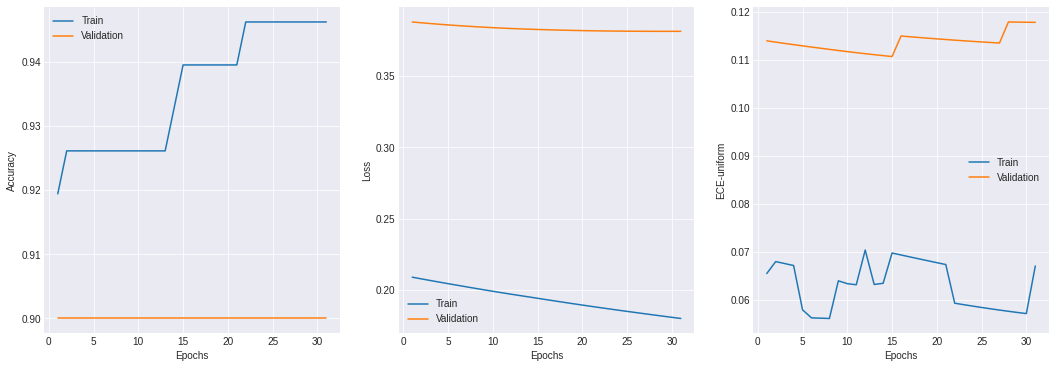

In [ ]:
## Plot history for the best dimension
HistoryPlot(his.loc[his["ncomp"] == best_dim,:])
plt.savefig(dir_kernel + 'history_' + "rbf_glass" + '.pdf', bbox_inches='tight')

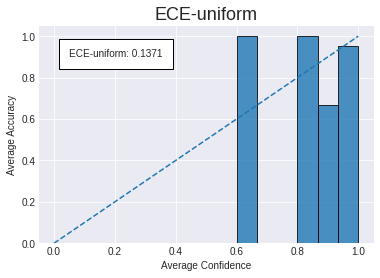

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax.loc[dmax["ncomp"] == best_dim,:], diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)
plt.savefig(dir_kernel + 'dmax_' + "rbf_glass" + '.pdf', bbox_inches='tight')

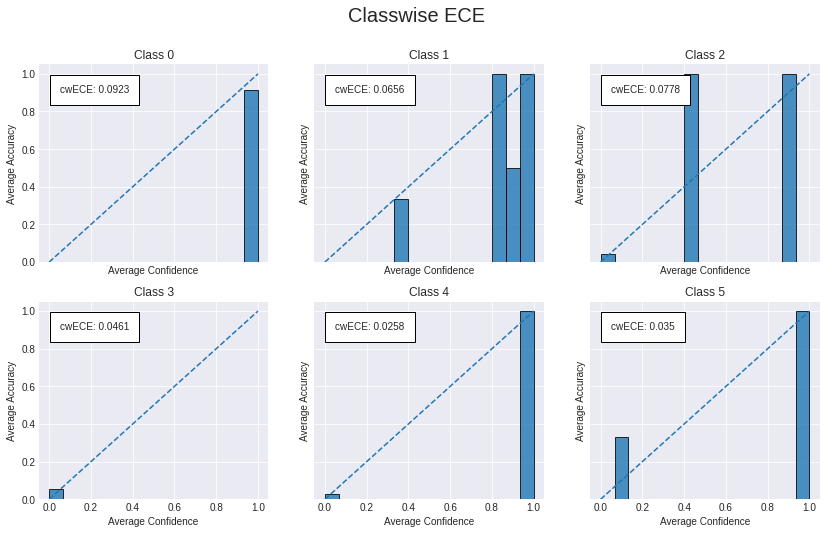

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw.loc[dcw["ncomp"] == best_dim,:], diagram = "cw", nr_plt = 2, nc_plt = 3, w_plt = 14, h_plt = 8)
plt.savefig(dir_kernel + 'dcw_' + "rbf_glass" + '.pdf', bbox_inches='tight')

## Cosine Kernel

In [ ]:
#============================#
#    Model with kernel       #
#============================#
class KQMCosine_Model(tf.keras.Model):
    def __init__(self, dim_x, dim_y, n_comp, sigma, coef0, dropout, nunits, sigma_train=True, l1_x=0, l1_y=0, l1_act=0):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp        
        self.sigma = tf.Variable(sigma, trainable = sigma_train, dtype = tf.float32)
        self.coef0 = tf.Variable(coef0, trainable = False, dtype = tf.float32)
        kernel = create_cos_kernel()
        self.kqmclass = KQMClassif(kernel, dim_x=dim_x, dim_y=dim_y, n_comp=n_comp)
    
    def call(self, inputs):
        ones = tf.ones_like(inputs[:, 0:1])
        rho_x = tf.keras.layers.concatenate((ones, inputs), axis=1)
        rho_x = tf.expand_dims(rho_x, axis=1)
        #----------------0
        rho_y_0 = self.kqmclass(rho_x)
        y_w_0 = rho_y_0[:, :, 0]
        y_v_0 = rho_y_0[:, :, 1:]
        norms_y_0 = tf.expand_dims(tf.linalg.norm(y_v_0, axis=-1), axis=-1)
        y_v_0 = y_v_0 / norms_y_0
        probs_0 = tf.einsum("...j,...ji->...i", y_w_0, y_v_0 ** 2, optimize="optimal")

        return probs_0

In [ ]:
#===============================================================#
#         Train model and calculate calibration metrics         #
#===============================================================#
his, gm, gm_ece, dmax, dcw = TrainModel(VisualModel = KQMCosine_Model, 
                                        X_train = X_train, y_train = y_train, y_train_bin = y_train_bin, 
                                        X_val = X_val, y_val = y_val, y_val_bin = y_val_bin,
                                        X_test = X_test, y_test = y_test, y_test_bin = y_test_bin, 
                                        epochs = 50,
                                        ncomp_list = [8,16,32,64,128], 
                                        sigma = 999,                                        
                                        sigma_lower = 999,
                                        sigma_upper = 1000,
                                        n_sigma = 1,
                                        coef0 = 999,
                                        dropout = 999, # 0.2
                                        nunits = 999, # 256
                                        init_lr = 0.001, # 0.01
                                        batch_size = 256,
                                        callbacks = callbacks)

Done Dimension: 8; Duration 2.08 (minutes)


Done Dimension: 16; Duration 2.22 (minutes)


Done Dimension: 32; Duration 1.93 (minutes)


Done Dimension: 64; Duration 1.88 (minutes)


Done Dimension: 128; Duration 1.96 (minutes)


In [ ]:
## Create folder for results of the kernel
dir_kernel = dir + "Cosine-Kernel/"

if(not os.path.exists(dir_kernel)):
  os.mkdir(dir_kernel)

print(dir_kernel)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/06_KQM/Glass/Cosine-Kernel/


In [ ]:
## Export results
his.to_csv(dir_kernel + "History_optimization.csv")
gm.to_feather(dir_kernel + "GM_optimization.feather")
gm_ece.to_feather(dir_kernel + "GM_ECE_optimization.feather")
dmax.to_feather(dir_kernel + "Diagram_Max.feather")
dcw.to_feather(dir_kernel + "Diagram_CW.feather")

In [ ]:
## Export results
his = pd.read_csv(dir_kernel + "History_optimization.csv")
gm = pd.read_feather(dir_kernel + "GM_optimization.feather")
gm_ece = pd.read_feather(dir_kernel + "GM_ECE_optimization.feather")
dmax = pd.read_feather(dir_kernel + "Diagram_Max.feather")
dcw = pd.read_feather(dir_kernel + "Diagram_CW.feather")

In [ ]:
#==========================================================#
#   Best results among all combinations of parameters      #
#==========================================================#
## Best results based on accuracy
best_dim = gm.sort_values(by = "acc_val", ascending = False).iloc[0,:]["ncomp"]

print(f"Best parameters: dimension rff: {best_dim}")

Best parameters: dimension rff: 512.0


In [ ]:
## Metrics of calibration for the best dimension
gm.loc[gm["ncomp"] == best_dim,:]

,ncomp,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test,sigma,coef0
3,512,1.084072,0.397141,1.413491,0.586977,0.785235,0.666667,0.666667,1.875,999.0


In [ ]:
## Metrics of calibration for the best dimension
gm_ece.loc[gm_ece["ncomp"] == best_dim,:]

,ncomp,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value,sigma,coef0
9,512,Maximum,TV,Data,0.249229,0.247074,0.041620,0.453,1.875,999.0
10,512,Maximum,TV,Uniform,0.295014,0.125435,0.046206,0.000,1.875,999.0
11,512,CW,-,Uniform,0.341625,0.323798,0.015723,0.128,1.875,999.0


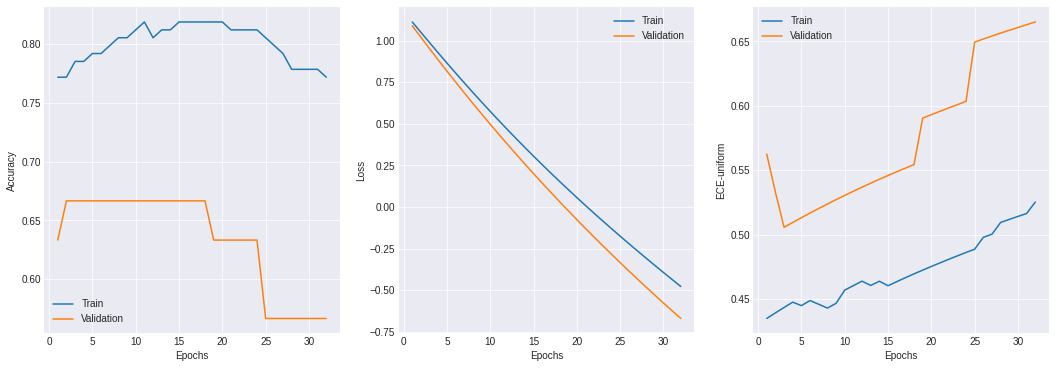

In [ ]:
## Plot history for the best dimension
HistoryPlot(his.loc[his["ncomp"] == best_dim,:])
plt.savefig(dir_kernel + 'history_' + "cosine_glass" + '.pdf', bbox_inches='tight')

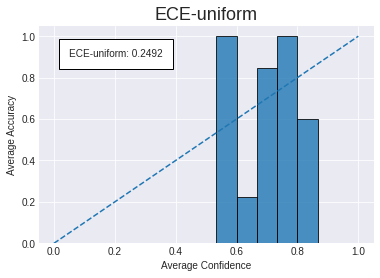

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax.loc[dmax["ncomp"] == best_dim,:], diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)
plt.savefig(dir_kernel + 'dmax_' + "cosine_glass" + '.pdf', bbox_inches='tight')

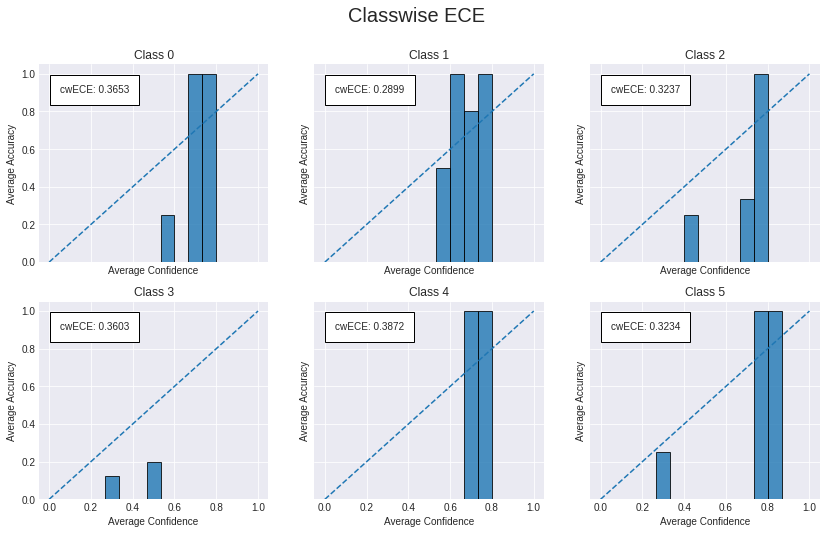

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw.loc[dcw["ncomp"] == best_dim,:], diagram = "cw", nr_plt = 2, nc_plt = 3, w_plt = 14, h_plt = 8)
plt.savefig(dir_kernel + 'dcw_' + "cosine_glass" + '.pdf', bbox_inches='tight')

## Polynomial Kernel

In [ ]:
#============================#
#    Model with kernel       #
#============================#
class KQMPoly_Model(tf.keras.Model):
    def __init__(self, dim_x, dim_y, n_comp, sigma, coef0, dropout, nunits, sigma_train=True, l1_x=0, l1_y=0, l1_act=0):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        self.sigma = tf.Variable(sigma, trainable = True, dtype = tf.float32)
        self.coef0 = tf.Variable(coef0, trainable = True, dtype = tf.float32)
        kernel = create_poly_kernel(gamma = self.sigma, degree = 2, coef0 = self.coef0)
        self.kqmclass = KQMClassif(kernel, dim_x=dim_x, dim_y=dim_y, n_comp=n_comp)        
    
    def call(self, inputs):
        ones = tf.ones_like(inputs[:, 0:1])
        rho_x = tf.keras.layers.concatenate((ones, inputs), axis=1)
        rho_x = tf.expand_dims(rho_x, axis=1)
        #----------------0
        rho_y_0 = self.kqmclass(rho_x)
        y_w_0 = rho_y_0[:, :, 0]
        y_v_0 = rho_y_0[:, :, 1:]
        norms_y_0 = tf.expand_dims(tf.linalg.norm(y_v_0, axis=-1), axis=-1)
        y_v_0 = y_v_0 / norms_y_0
        probs_0 = tf.einsum("...j,...ji->...i", y_w_0, y_v_0 ** 2, optimize="optimal")

        return probs_0

In [ ]:
#===============================================================#
#         Train model and calculate calibration metrics         #
#===============================================================#
his, gm, gm_ece, dmax, dcw = TrainModel(VisualModel = KQMPoly_Model, 
                                        X_train = X_train, y_train = y_train, y_train_bin = y_train_bin, 
                                        X_val = X_val, y_val = y_val, y_val_bin = y_val_bin,
                                        X_test = X_test, y_test = y_test, y_test_bin = y_test_bin, 
                                        epochs = 50,
                                        ncomp_list = [8, 16, 32, 64, 128],
                                        sigma = 0.5,
                                        sigma_lower = 0.001,
                                        sigma_upper = 2,
                                        n_sigma = 41,
                                        coef0 = 0.5,
                                        dropout = 999, # 0.2
                                        nunits = 999, # 256
                                        init_lr = 0.05, # 0.01
                                        batch_size = 256,
                                        callbacks = callbacks)

Done Dimension: 8; Duration 7.00 (minutes)
Done Dimension: 16; Duration 7.09 (minutes)
Done Dimension: 32; Duration 7.39 (minutes)
Done Dimension: 64; Duration 7.24 (minutes)
Done Dimension: 128; Duration 7.53 (minutes)


In [ ]:
## Create folder for results of the kernel
dir_kernel = dir + "Polynomial-Kernel/"

if(not os.path.exists(dir_kernel)):
  os.mkdir(dir_kernel)

print(dir_kernel)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/06_KQM/Glass/Polynomial-Kernel/


In [ ]:
## Export results
his.to_csv(dir_kernel + "History_optimization.csv")
gm.to_feather(dir_kernel + "GM_optimization.feather")
gm_ece.to_feather(dir_kernel + "GM_ECE_optimization.feather")
dmax.to_feather(dir_kernel + "Diagram_Max.feather")
dcw.to_feather(dir_kernel + "Diagram_CW.feather")

In [ ]:
## Export results
his = pd.read_csv(dir_kernel + "History_optimization.csv")
gm = pd.read_feather(dir_kernel + "GM_optimization.feather")
gm_ece = pd.read_feather(dir_kernel + "GM_ECE_optimization.feather")
dmax = pd.read_feather(dir_kernel + "Diagram_Max.feather")
dcw = pd.read_feather(dir_kernel + "Diagram_CW.feather")

In [ ]:
#==========================================================#
#   Best results among all combinations of parameters      #
#==========================================================#
## Best results based on accuracy
best_dim = gm.sort_values(by = "acc_val", ascending = False).iloc[0,:]["ncomp"]

print(f"Best parameters: dimension rff: {best_dim}")

Best parameters: dimension rff: 32.0


In [ ]:
## Metrics of calibration for the best dimension
gm.loc[gm["ncomp"] == best_dim,:]

,ncomp,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test,sigma,coef0
2,32,0.253637,0.245247,0.598249,0.401995,0.912752,0.9,0.9,0.261472,0.258456


In [ ]:
## Metrics of calibration for the best dimension
gm_ece.loc[gm_ece["ncomp"] == best_dim,:]

,ncomp,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value,sigma,coef0
6,32,Maximum,TV,Data,0.141622,0.201915,0.040423,0.947,0.261472,0.258456
7,32,Maximum,TV,Uniform,0.203681,0.155703,0.040273,0.129,0.261472,0.258456
8,32,CW,-,Uniform,0.080818,0.206422,0.020584,1.000,0.261472,0.258456


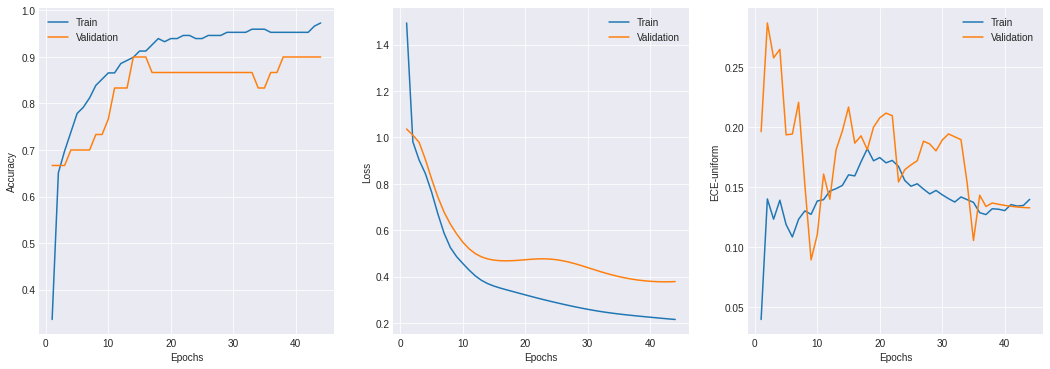

In [ ]:
## Plot history for the best dimension
HistoryPlot(his.loc[his["ncomp"] == best_dim,:])
plt.savefig(dir_kernel + 'history_' + "poly_glass" + '.pdf', bbox_inches='tight')

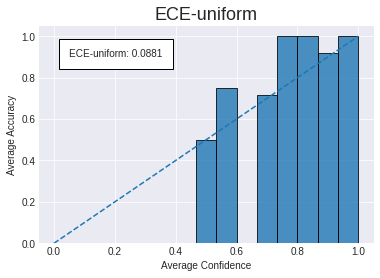

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax.loc[dmax["ncomp"] == best_dim,:], diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)
plt.savefig(dir_kernel + 'dmax_' + "poly_glass" + '.pdf', bbox_inches='tight')

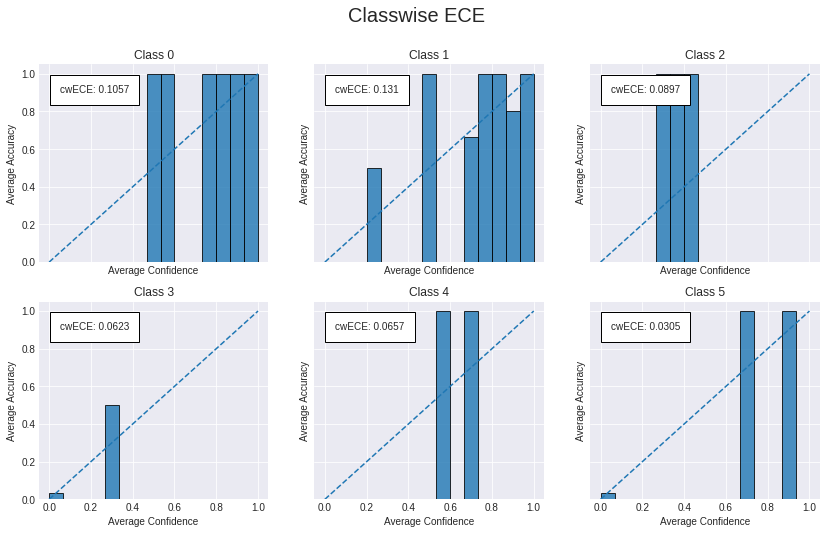

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw.loc[dcw["ncomp"] == best_dim,:], diagram = "cw", nr_plt = 2, nc_plt = 3, w_plt = 14, h_plt = 8)
plt.savefig(dir_kernel + 'dcw_' + "poly_glass" + '.pdf', bbox_inches='tight')